In [11]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

#import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [12]:
# Manual Adjust here
import os
print(os.getcwd())
#os.chdir("Projects/maskrcnn-benchmark2")

/Users/mingrenshen/Projects/maskrcnn-benchmark2/demo


In [13]:
from os import path
import sys
sys.path.append(path.join(path.dirname(os.getcwd()), ''))
sys.path.append(path.join(path.dirname(os.getcwd())))
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo
from coco import COCO

In [14]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [15]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [16]:
config_file = "../configs/predict.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [18]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

FileNotFoundError: [Errno 2] No such file or directory: '/srv/home/shenmr/MaskRCNNPyTorch/maskrcnn-benchmark2/output/model_final.pth'

Let's define a few helper functions for loading images from a URL

In [7]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

In [1]:
# from http://cocodataset.org/#explore?id=345434
import cv2
image_name = "0501_300kx_1nm_clhaadf3_0006.jpg"
image = cv2.imread("../datasets/val/" + image_name)
cv2.imshow("a.jpg",image)

NameError: name 'imshow' is not defined

In [9]:
coco=COCO("../datasets/annotation/test.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


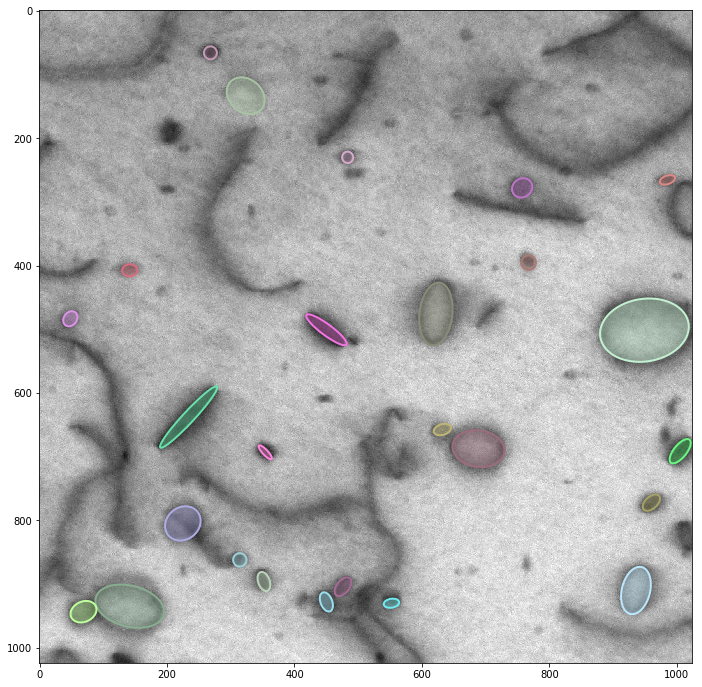

In [10]:
import json
catIds = coco.getCatIds()
imgIds = coco.getImgIds(catIds=catIds );
labels = list()
with open('../datasets/annotation/test.json') as json_data:
    annotation = json.loads(json_data.read())
    images = annotation['images']
    for i in range(len(images)):
        if(images[i]["file_name"] == image_name):
            imgId = images[i]["id"]
    
    seg = annotation['annotations']
    for i in range(len(seg)):
        if seg[i]['image_id'] == imgId:
            labels.append(seg[i]['category_id'])
    
img = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
plt.imshow(image)
coco.showAnns(anns)

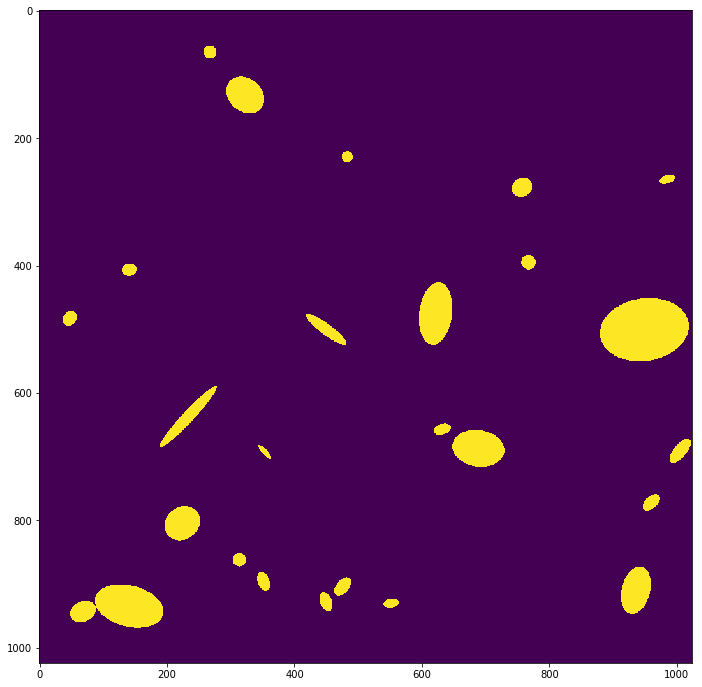

In [11]:
gt_allMask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type1Mask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type2Mask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type3Mask = np.zeros(coco.annToMask(anns[0]).shape)
for i in range(len(anns)):
    if labels[i] == 1:
        gt_type1Mask += coco.annToMask(anns[i])
        gt_type1Mask[gt_type1Mask >= 2] = 1
    if labels[i] == 2:
        gt_type2Mask += coco.annToMask(anns[i])
        gt_type2Mask[gt_type2Mask >= 2] = 1
    if labels[i] == 3:
        gt_type3Mask += coco.annToMask(anns[i])
        gt_type3Mask[gt_type3Mask >= 2] = 1
        
    gt_allMask += coco.annToMask(anns[i])
plt.imshow(gt_allMask)

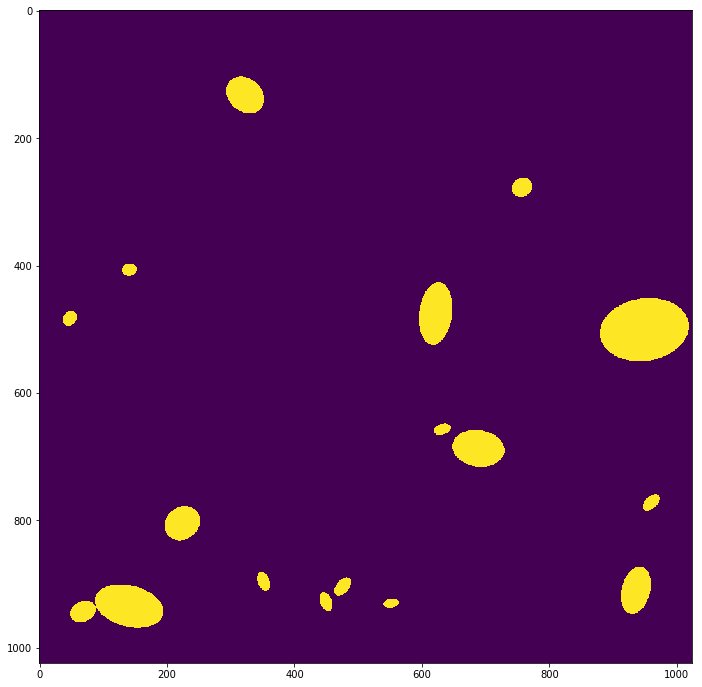

In [12]:
plt.imshow(gt_type1Mask)

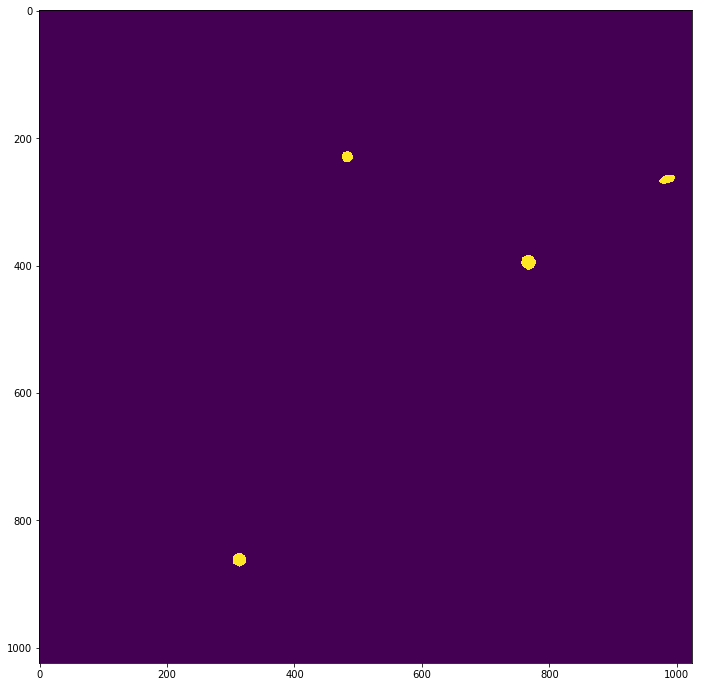

In [15]:
plt.imshow(gt_type2Mask)

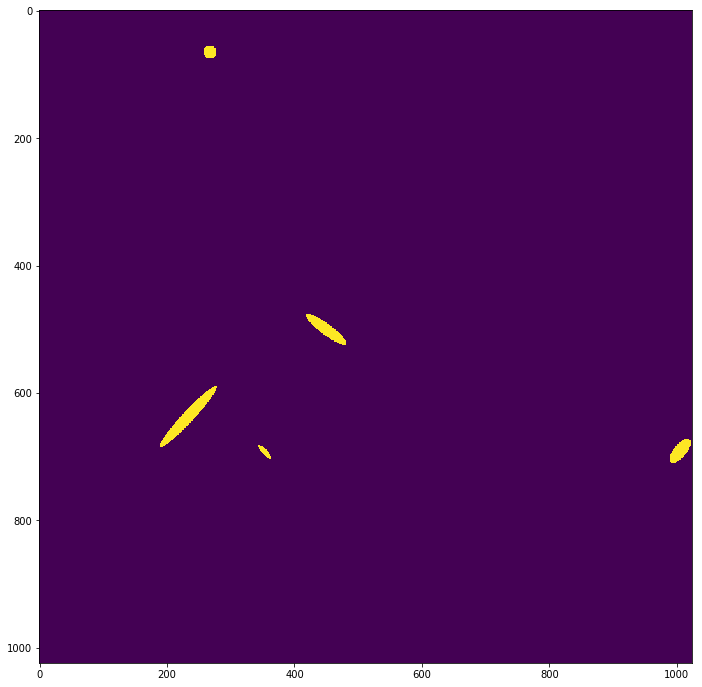

In [16]:
plt.imshow(gt_type3Mask)

# Computing the predictions

We provide a run_on_opencv_image function, which takes an image as it was loaded by OpenCV (in BGR format), and #computes the predictions on them, returning an image with the predictions overlayed on the image.


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 1,
        2, 2, 2, 3, 2, 1, 2, 1, 2, 1])
[[1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [1, 127, 31], [2, 254, 62], [2, 254, 62], [2, 254, 62], [1, 127, 31], [1, 127, 31], [1, 127, 31], [2, 254, 62], [1, 127, 31], [3, 126, 93], [2, 254, 62], [2, 254, 62], [2, 254, 62], [1, 127, 31], [2, 254, 62], [2, 254, 62], [2, 254, 62], [3, 126, 93], [2, 254, 62], [1, 127, 31], [2, 254, 62], [1, 127, 31], [2, 254, 62], [1, 127, 31]]
34


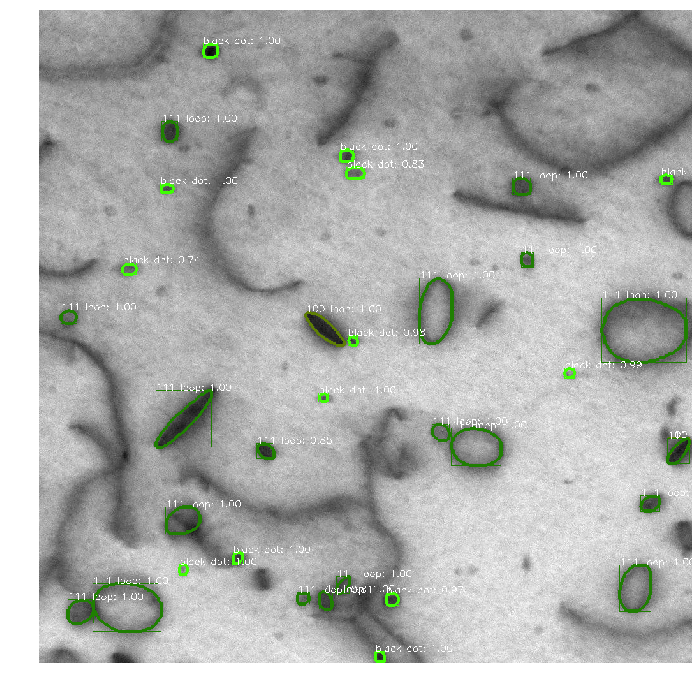

In [17]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [18]:
mask, labels = coco_demo.get_predicted_mask_labels(image)
print(mask[0])
new_labels = np.zeros(len(labels))
for i in range(len(labels)):
    new_labels[i] = labels[i].item()
print(new_labels)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 1. 3. 2. 2. 2. 1.
 2. 2. 2. 3. 2. 1. 2. 1. 2. 1.]


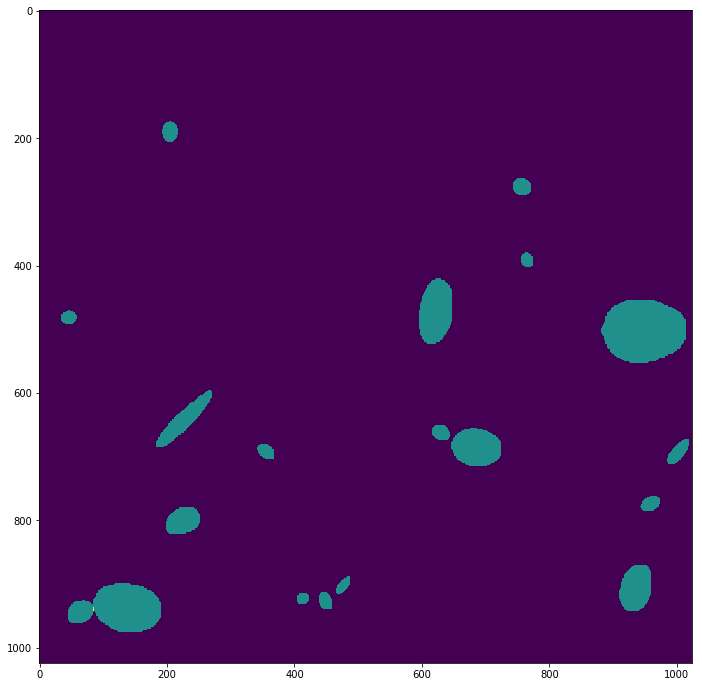

In [19]:
pred_mask = np.zeros((1024,1024,3))
for i in range(len(new_labels)):

    if new_labels[i] == 1:
        pred_mask[:,:,0] += mask[i][0]
    if new_labels[i] == 2:
        pred_mask[:,:,1] += mask[i][0]
    if new_labels[i] == 3:
        pred_mask[:,:,2] += mask[i][0]
plt.imshow(pred_mask[:,:,0])

In [20]:
type1_pred = [];
type2_pred = [];
type3_pred = [];
allTypes_pred = [];
class_ids = [1,2,3]
mask1 = np.zeros((1024,1024)) # for this image
mask2 = np.zeros((1024,1024))
mask3 = np.zeros((1024,1024))
allmask = np.zeros((1024,1024))
mask = pred_mask
#print(class_ids)

for j in range(len(class_ids)):
    this_channel = mask[:,:,j]
    class_id = class_ids[j]
#     print(np.count_nonzero(this_channel))
    if class_id == 1:
        mask1 = mask1 + this_channel
        
        mask1[mask1 >= 2] = 1
            
    elif class_id == 2:
        mask2 = mask2 + this_channel
        mask2[mask2 >= 2] = 1
        
    else:
        mask3 = mask3 + this_channel
        mask3[mask3 >= 2] = 1
            
    allmask = allmask + this_channel
    allmask[allmask >= 2] = 1
        
#print(np.count_nonzero(mask1)/(1024*1024))        
type1_pred.append(mask1)
type2_pred.append(mask2)
type3_pred.append(mask3)
allTypes_pred.append(allmask)
print(len(type1_pred))

1


In [22]:
type1_union = []
type2_union = []
type3_union = []
alltypes_union = []
type1_intersection = []
type2_intersection = []
type3_intersection = []
alltypes_intersection = []
type1_iou = []
type2_iou = []
type3_iou = []
alltypes_iou = []
type1_precision = []
type2_precision = []
type3_precision = []
alltypes_precision = []
type1_recall = []
type2_recall = []
type3_recall = []
alltypes_recall = []

type1_F1 = []
type2_F1 = []
type3_F1 = []
alltypes_F1 = []
i = 0
# for i in range(): 
gt_mask1 = gt_type1Mask  #the first type gt mask of this ith image
gt_mask2 = gt_type2Mask 
gt_mask3 = gt_type3Mask 
gt_allmask = gt_allMask 
    
pred_mask1 = type1_pred[i]
pred_mask2 = type2_pred[i]
pred_mask3 = type3_pred[i]
pred_allmask = allTypes_pred[i]
    
    
type1_union.append(np.count_nonzero(gt_mask1+pred_mask1))
type2_union.append(np.count_nonzero(gt_mask2+pred_mask2))
type3_union.append(np.count_nonzero(gt_mask3+pred_mask3))
alltypes_union.append(np.count_nonzero(gt_allmask+pred_allmask))
    
    

type1_intersection.append(np.count_nonzero((gt_mask1+pred_mask1) == 2))
type2_intersection.append(np.count_nonzero((gt_mask2+pred_mask2) == 2))
type3_intersection.append(np.count_nonzero((gt_mask3+pred_mask3) == 2))
alltypes_intersection.append(np.count_nonzero((gt_allmask+pred_allmask) == 2)) 

type1_iou.append(type1_intersection[i]/type1_union[i])


type2_iou.append(type2_intersection[i]/type2_union[i])


type3_iou.append(type3_intersection[i]/type3_union[i])

alltypes_iou.append(alltypes_intersection[i]/alltypes_union[i])

type1_precision.append(type1_intersection[i]/np.count_nonzero((pred_mask1)))


type2_precision.append(type2_intersection[i]/np.count_nonzero((pred_mask2)))

type3_precision.append(type3_intersection[i]/np.count_nonzero((pred_mask3)))

alltypes_precision.append(alltypes_intersection[i] / np.count_nonzero(pred_allmask))

type1_recall.append(type1_intersection[i]/np.count_nonzero((gt_mask1)))

type2_recall.append(type2_intersection[i]/np.count_nonzero((gt_mask2)))
type3_recall.append(type3_intersection[i]/np.count_nonzero((gt_mask3)))
alltypes_recall.append(alltypes_intersection[i] / np.count_nonzero(gt_allmask))

type1_F1.append(2*(type1_recall[i]* type1_precision[i]) / (type1_recall[i] + type1_precision[i]))
type2_F1.append(2*(type2_recall[i] * type2_precision[i]) / (type2_recall[i] + type2_precision[i]))
type3_F1.append(2*(type3_recall[i] * type3_precision[i]) / (type3_recall[i] + type3_precision[i]))
alltypes_F1.append(2*(alltypes_recall[i] * alltypes_precision[i]) / (alltypes_recall[i] + alltypes_precision[i]))
# # recall
# if np.count_nonzero((gt_mask1)) > 0:
#     type1_recall.append(type1_intersection[i]/np.count_nonzero((gt_mask1)))
# else:
#     type1_recall.append(0)
# if np.count_nonzero((gt_mask2)) > 0:
#     type2_recall.append(type2_intersection[i]/np.count_nonzero((gt_mask2)))
# else:
#     type2_recall.append(0)
# if np.count_nonzero((gt_mask3)) > 0:
#     type3_recall.append(type3_intersection[i]/np.count_nonzero((gt_mask3)))
# else:
#     type3_recall.append(0)
# alltypes_recall.append(alltypes_intersection[i] / np.count_nonzero(gt_allmask))
    
# if type1_recall[i] + type1_precision[i] > 0:
#     type1_F1.append(2*(type1_recall[i]* type1_precision[i]) / (type1_recall[i] + type1_precision[i]))
# else:
#     type1_F1.append(0)
# if type2_recall[i] + type2_precision[i] > 0:
#     type2_F1.append(2*(type2_recall[i] * type2_precision[i]) / (type2_recall[i] + type2_precision[i]))
# else:
#     type2_F1.append(0)
# if type3_recall[i] + type3_precision[i] > 0:
#     type3_F1.append(2*(type3_recall[i] * type3_precision[i]) / (type3_recall[i] + type3_precision[i]))
# else:
#     type3_F1.append(0)
# if (alltypes_recall[i] + alltypes_precision[i]) > 0:
#     alltypes_F1.append(2*(alltypes_recall[i] * alltypes_precision[i]) / (alltypes_recall[i] + alltypes_precision[i]))
# else:
#     alltypes_F1.append(0)

In [23]:
print('111 loop iou')
print(type1_iou)
print('blackdot iou')
print(type2_iou)
print('100 loop iou')
print(type3_iou)
print('all types iou')
print(alltypes_iou)

111 loop iou
[0.6876191743159948]
blackdot iou
[0.15775465763368013]
100 loop iou
[0.3644597800301919]
all types iou
[0.7271292745286034]


In [24]:
print('111 loop precision')
print(type1_precision)
print('blackdot precision')
print(type2_precision)
print('100 loop precision')
print(type3_precision)
print('all types precision')
print(alltypes_precision)

111 loop precision
[0.7886331849968213]
blackdot precision
[0.18543799772468714]
100 loop precision
[0.7738095238095238]
all types precision
[0.822387891110358]


In [25]:
print('111 loop recall')
print(type1_recall)
print('blackdot recall')
print(type2_recall)
print('100 loop recall')
print(type3_recall)
print('all types recall')
print(alltypes_recall)

111 loop recall
[0.8429736341397118]
blackdot recall
[0.5137903861308116]
100 loop recall
[0.4079169683804007]
all types recall
[0.8625894507369319]


In [26]:
print('111 loop F1')
print(type1_F1)
print('blackdot F1')
print(type2_F1)
print('100 loop F1')
print(type3_F1)
print('all types F1')
print(alltypes_F1)

111 loop F1
[0.814898508835315]
blackdot F1
[0.27251828631138975]
100 loop F1
[0.534218428955271]
all types F1
[0.8420090901731296]
